# DECEPTIVE REVIEW CLASSIFIER

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
import spacy
from spacy.util import minibatch
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [3]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [4]:
df.shape

(1600, 5)

In [5]:
df['deceptive'].value_counts()

deceptive    800
truthful     800
Name: deceptive, dtype: int64

In [6]:
df['polarity'].value_counts()

negative    800
positive    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [7]:
df['hotel'].value_counts()

allegro             80
palmer              80
intercontinental    80
amalfi              80
swissotel           80
fairmont            80
hyatt               80
sofitel             80
talbott             80
hardrock            80
james               80
omni                80
conrad              80
homewood            80
affinia             80
hilton              80
sheraton            80
monaco              80
ambassador          80
knickerbocker       80
Name: hotel, dtype: int64

In [8]:
df['source'].value_counts()

MTurk          800
Web            400
TripAdvisor    400
Name: source, dtype: int64

### EDA

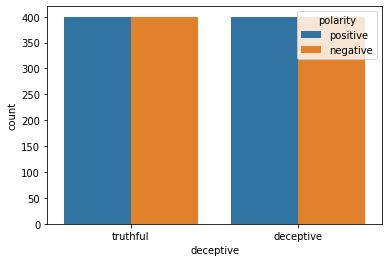

In [9]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

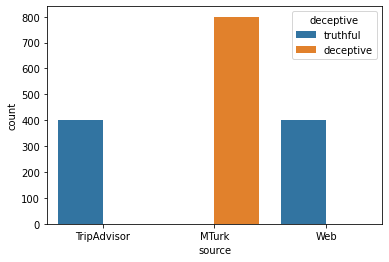

In [10]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [11]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [12]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [13]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [14]:
#z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
#df['deceptive'] = df['deceptive'].map(z)

In [15]:
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [16]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [17]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [18]:
x = df['text']
y = df['deceptive']

### TEXT AUGMENTATION USING SYNONYM REPLACEMENT

In [19]:
!pip install nlpaug

     |████████████████████████████████| 405 kB 9.4 MB/s 


In [20]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
nltk.download('averaged_perceptron_tagger')

from nlpaug.util import Action

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [21]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=5)

In [22]:
augmented_sentences=[]
augmented_sentences_labels=[]
for i in x.index:
  if y[i]==0:
    temps=aug.augment(x[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(0)
  else :
    temps=aug.augment(x[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(1)

In [23]:
# after augumenting, our dataset is multiplied with 10 times.
x=x.append(pd.Series(augmented_sentences),ignore_index=True)
y=y.append(pd.Series(augmented_sentences_labels),ignore_index=True)

In [24]:
df1=pd.DataFrame({'review':x,'sentiment':y})
df1.head()

,review,sentiment
0,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",1
1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",1
2,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",1
3,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",1
4,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n",1


In [25]:
df1.shape

(17600, 2)

### DATA PREPROCESSING USING SPACY

As we are using spaCy, to train our model let’s import the package. After importing, you can load a pre-trained model like "en_core_web_sm". We will be adding / modifying the text classifier to this model later. For any spaCy model, you can view the pipeline components present in the current pipeline through pipe_names method.

In [26]:
import string
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [28]:
# Loading a Spacy pretrained model
nlp=spacy.load("en_core_web_sm")
nlp.pipe_names

['tagger', 'parser', 'ner']

We can see that the pipeline has tagger, parser and NER[Named Entity Recognition]. It doesn’t have a text classifier. So, let’s just add the built-in textcat pipeline component of spaCy for text classification to our pipeline. The add_pipe() method can be used for this.

In [29]:
# Adding the built-in textcat component to the pipeline.
# Now, we are going to train the textcat with our text dataset using the simple_cnn architecture.
textcat=nlp.create_pipe( "textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"})
nlp.add_pipe(textcat, last=True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

First, we need to add the desired labels to the pipeline component. In this case, it is POSITIVE and NEGATIVE as per the reviews. Add these labels to textcat using add_label function.

In [30]:
# Adding the labels to textcat
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

1

Our default model with textcat is ready. We just need to prepare the data in the required format.

We write a function load_data() which takes a list of tuples as input. Each tuple contains the text and label value( 0 or 1 ). The below code demonstrates how to convert our reviews data set into this desired format

In [31]:
# Converting the dataframe into a list of tuples
df1['tuples'] = df1.apply(lambda row: (row['review'],row['sentiment']), axis=1)
train =df1['tuples'].tolist()
train[:10]

[('We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n',
  1),
 ('Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n',
  1),
 ("This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend an

Next, We pass the train data as input to a load_data() function.

The load_data() function performs the below functions:
1. Shuffle the data using random.shuffle() function This prevents any training based on the order of examples.
2. For each tuple in the input data , category is assigned as ‘POSITIVE’ or ‘NEGATIVE’ based on the label value and stored in cats
3. 80 % of the input data will be used for training, whereas 20% for evaluation. 

After defining the function , pass the list of tuples train to the above function. The function will return the texts and cats for both training and evaluation. 

In [32]:
import random

def load_data(limit=0, split=0.8):
    train_data=train
    # Shuffle the data
    random.shuffle(train_data)
    texts, labels = zip(*train_data)
    # get the categories for each review
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]

    # Splitting the training and evaluation data
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

n_texts=17600

# Calling the load_data() function 
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)

# Processing the final format of training data
train_data = list(zip(train_texts,[{'cats': cats} for cats in train_cats]))
train_data[:10]

[('This is the hotel for the discriminating business traveler. It offers spacious rooms that are elegant and refined. With a cozy area complete with chairs and fireplace, they are the perfect place to think about clients or discuss strategy for a business meeting with a co worker. The restaurant offers just the emplacement to impress a perspective client. And all of this elegance and refinement in the heart of downtown Chicago',
  {'cats': {'NEGATIVE': True, 'POSITIVE': False}}),
 ("I stayed at the Chicago Hilton because it was host to a conference I was attending. Before I arrived I tried to find out about the ' In Room Fitness ' program advertize on the corporate website. I called the 800 reservation number and the client service representative answered that the hotel did have a fitness center. I explained that I was inquiring about the ' In Room Fitness ' advertised on their website. She put me on hold and came back a few minutes later and told me that there was no such thing and th

Till now, we have prepared the training data in the desired format and stored it in train_data variable. evaluate() function will take the textcat, and the evaluation data as input. For each of the text in evaluation data, it reads the score from the predictions made. And based on this, it calculates the values of True positive, True negative, False positive and false negative.

In [33]:
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


#("Number of training iterations", "n", int))
n_iter=10

### MODEL BUILDING USING SIMPLE CNN

The data is stored in train_data() variable and the component in texcat.

Before we train, we need to disable the other pipeline components except textcat. This is to prevent the other components from getting affected while training. It can be accomplished through the disable_pipes() method. Next, use the begin_training() function that will return us an optimizer.

The minibatch() function of spaCy will return you the training data in batches. It takes the size parameter to denote the batch size. The compounding() function takes three inputs which are start (the first integer value) ,stop (the maximum value that can be generated) and finally compound. This value stored in compound is the compounding factor for the series. 

For each iteration , the model is updated through the nlp.update() command. Parameters of nlp.update() are :

    1. docs: This expects a batch of texts as input. We can pass each batch to the zip method.

    2. golds: We can pass the annotations (got through the zip method).

    3. drop: This represents the dropout rate.

    4. losses: A dictionary to hold the losses against each pipeline component. Create an empty dictionary and pass it here.



In [34]:
from spacy.util import minibatch, compounding

# Disabling other components
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()

    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))

    # Performing training
    for i in range(n_iter):
        losses = {}
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)

      # Calling the evaluate() function and printing the scores
        with textcat.model.use_params(optimizer.averages):
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
9.425	0.992	0.992	0.992
1.652	0.998	0.999	0.999
0.471	0.999	1.000	0.999
0.491	0.999	1.000	0.999
0.352	0.998	1.000	0.999
0.069	0.998	1.000	0.999
0.246	0.999	1.000	0.999
0.071	0.999	1.000	1.000
0.071	1.000	1.000	1.000
0.022	0.999	1.000	1.000


### MODEL EVALUATION

In [35]:
# Testing the model
test_text = "bad hotel and aggressive staff"
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 0.9999997615814209, 'POSITIVE': 1.8691370939905028e-07}

In [36]:
test_text = "My wife and I came to spend the weekend in downtown Chicago for shopping and we found this Conrad hotel well located close to everything downtown and of a size that doesn't make you feel lost in the Convention world. We have had this feeling when staying at larger hotels in the past. Our Suite has view on Michigan avenue with a bit of the Lake at the end. Staff was very professional, pleasant and friendly making us feel very comfortable. Internet is free n the rooms and I am making my review from there. "
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 1.6778597000666196e-06, 'POSITIVE': 0.9999983310699463}

In [37]:
test_text = "We stayed at the Conrad for 2 nights for a friends reunion. The room was clean and new feeling, nice city view, free bottled water in room upon arrival. Check in was a breeze, and our room was ready even though we were several hours early. All staff was friendly and helpful, excellent breakfast."
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 7.817983771474246e-08, 'POSITIVE': 0.9999998807907104}

In [38]:
test_text = "Great Hotel, we always love breakfast in morning,and drinks in even when applicable. Around the corner from magnificent Mile,and close to lots of restaurants. Staff was great, we even checked in early before noon,and other room available less than hour later."
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 1.0664180042502247e-13, 'POSITIVE': 1.0}

In [39]:
test_text = "I totally LOVED IT here!! When you called either the Front Desk or Room Service, the phone was answered with nice manner"
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 0.006482305936515331, 'POSITIVE': 0.9935177564620972}

In [40]:
test_text = "good morning! very good hotel. i would suggest this hotel to everyone"
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 0.9903290271759033, 'POSITIVE': 0.009670901112258434}

In [41]:
test_text = "For 250 dollars, cheapest room available at the Hard Rock Hotel Chicago, you would assume you would have access to wifi. Yet, that was not the case. I was told I 'could have had' internet if I had booked through the site, which I didnt. The lady in the reception had no idea what she was talking about and had to ask around about internet access in general."
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 1.0, 'POSITIVE': 2.3181233321789563e-10}

In [42]:
test_text = "The atmosphere at the Talbott Hotel is very welcoming when you first walk in. The employees are friendly and will greet you when you first arrive. The hotel seems to be luxurious, even from the lobby, and right away, I was very excited for my stay! I stayed in a double queen room with my friend. The room is spacious enough, and beds are very comfortable. I didn't try the room service, but they do have a fitness club close by with a spa, which is very convenient. I also love how the room has individual climate controls! Very neat! Also handy that there is an iHome in the room. I'm usually stuck using just a regular alarm clock radio at other hotels. I will most likely stay in this hotel another time. It was a wonderful experience!"
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 1.0, 'POSITIVE': 1.164812801768278e-09}

In [43]:
test_text = "The staff was very polite and helpfull and the rooms were very comfortable and felt like home."
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 1.0, 'POSITIVE': 3.016574368075453e-08}

In [44]:
test_text = "this hotel staff is good towards me!!!"
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 1.0, 'POSITIVE': 5.404613930871938e-13}